In [34]:
import os
import torch
import pickle
import numpy as np
from torch.utils.data import Subset, DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.data import Dataset
from PIL import Image

In [13]:
class CropDataset(Dataset):
    def __init__(self, root_dir, augment=False):
        self.root_dir = root_dir
        self.image_paths = []
        self.labels = []
        self.class_names = sorted(os.listdir(root_dir))
        self.augment = augment

        valid_extensions = ('.bmp', '.png', '.jpg', '.jpeg')

        for label, class_name in enumerate(self.class_names):
            class_path = os.path.join(root_dir, class_name)
            for image_name in os.listdir(class_path):
                if image_name.lower().endswith(valid_extensions):
                    image_path = os.path.join(class_path, image_name)
                    self.image_paths.append(image_path)
                    self.labels.append(label)

        # Data augmentation transformations
        self.augmentation_transforms = transforms.Compose([
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomVerticalFlip(p=0.2),
            transforms.RandomRotation(degrees=20),
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
            transforms.RandomResizedCrop(size=(224, 224), scale=(0.8, 1.0))
        ])

        # Standard preprocessing transformations
        self.preprocess_transforms = transforms.Compose([
            transforms.Resize((224, 224)),  # Resize for VGG/ResNet input
            transforms.ToTensor(),
            transforms.Normalize(
                mean=[0.485, 0.456, 0.406],  # ImageNet normalization
                std=[0.229, 0.224, 0.225]
            )
        ])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        label = self.labels[idx]

        try:
            image = Image.open(image_path).convert("RGB")
            
            # Apply augmentation if enabled
            if self.augment:
                image = self.augmentation_transforms(image)
                
            # Apply standard preprocessing
            image = self.preprocess_transforms(image)
            
        except Exception as e:
            raise ValueError(f"Failed to load image: {image_path} — {e}")

        return image, torch.tensor(label, dtype=torch.long)

In [31]:
# Paths
test_split_path = 'test_split_indices.pkl'
best_model_path = 'crop_best_model_efficientNet.pth'
output_file = 'test_predictions.csv'
root_dir = 'D:/DOCS/PYTHON/CropDisease/Crop___DIsease'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [26]:
# Load Test Split
with open(test_split_path, 'rb') as f:
    test_indices = pickle.load(f)

# DataLoader Setup
full_dataset = CropDataset(root_dir=root_dir, augment=False)
test_dataset = Subset(full_dataset, test_indices)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=0, pin_memory=True)

In [29]:
import torch
import torch.nn as nn
import torchvision.models as models

class EfficientNetFineTune(nn.Module):
    def __init__(self, num_class, hidden_units, dropout_rate):
        super().__init__()
        self.efficientnet = models.efficientnet_b0(pretrained=True)
        in_features = self.efficientnet.classifier[1].in_features
        self.efficientnet.classifier = nn.Sequential(
            nn.Linear(in_features, hidden_units),
            nn.BatchNorm1d(hidden_units),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_units, num_class)
        )

    def forward(self, x):
        return self.efficientnet(x)

In [32]:
num_classes = 15        # Replace with your actual number of classes
hidden_units = 512      # Use the same value as during training
dropout_rate = 0.3      # Use the same value as during training

# Instantiate your model
model = EfficientNetFineTune(num_class=num_classes, hidden_units=hidden_units, dropout_rate=dropout_rate)

# Load weights (state dict)
state_dict = torch.load(best_model_path, map_location=device)
model.load_state_dict(state_dict)

# Move model to device and set to evaluation mode
model.to(device)
model.eval()

C:\Users\Mushfiq\AppData\Local\Temp\ipykernel_8396\4158288555.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(best_model_path, map_location=devic

EfficientNetFineTune(
  (efficientnet): EfficientNet(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): MBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
              (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
            (1): SqueezeExcitation(
              (avgpool): AdaptiveAvgPool2d(output_size=1)
              (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (activation): SiLU(inplace=True)
        

In [36]:
predictions = []
image_names = [full_dataset.image_paths[idx] for idx in test_indices]  # list of image paths
class_names = full_dataset.class_names  # list of class names

with torch.no_grad():
    for inputs, _ in tqdm(test_loader, desc="Running Inference"):
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        predictions.extend(preds.cpu().numpy())

# Save predictions with class names to CSV
output_file = 'test_predictions.csv'
with open(output_file, 'w') as f:
    f.write("Image,Prediction\n")
    for name, pred in zip(image_names, predictions):
        class_name = class_names[pred]  # map index to class name
        f.write(f"{os.path.basename(name)},{class_name}\n")

print(f"Predictions saved to {output_file}")

Running Inference: 100%|█████████████████████████████████████████████████████████████| 292/292 [00:57<00:00,  5.07it/s]

Predictions saved to test_predictions.csv


Number of images to plot: 9


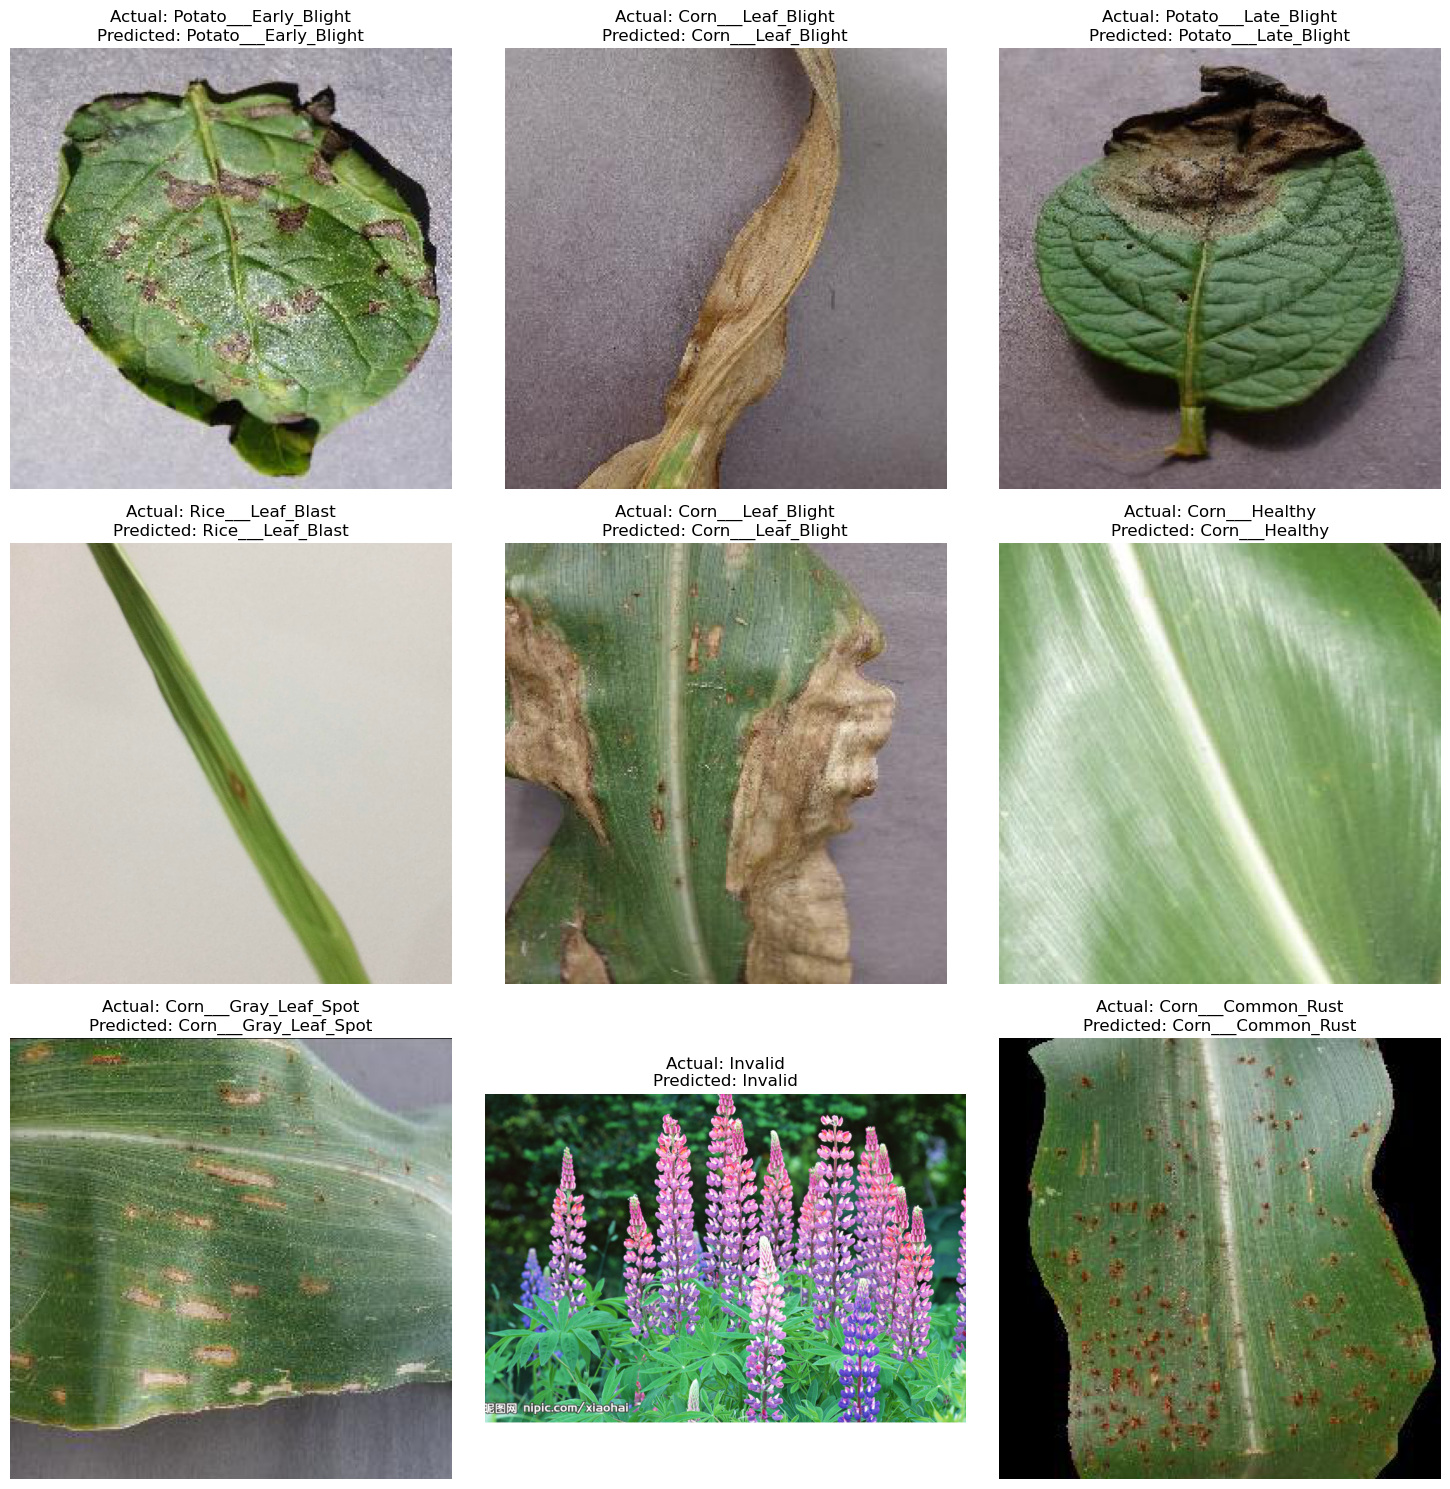

In [45]:
import matplotlib.pyplot as plt
from PIL import Image
import torch
from torchvision import transforms
import os

# ---------------------------
# Configuration (update these)
# ---------------------------

# List of image paths you want to visualize
image_paths = [
    'D:\\DOCS\\PYTHON\\CropDisease\\Crop___DIsease\\Potato___Early_Blight\\655010d0-0bf7-4cba-8ebe-591a8bc5f552___RS_Early.B 7668_flipTB.JPG',
    'D:\\DOCS\\PYTHON\\CropDisease\\Crop___DIsease\\Corn___Leaf_Blight\\7348d45f-96ba-454e-b0eb-084d0284f718___RS_NLB 4242(1).JPG',
    'D:\\DOCS\\PYTHON\\CropDisease\\Crop___DIsease\\Potato___Late_Blight\\98a806fd-2839-4069-b40b-08522c34ccdc___RS_LB 3032.JPG',
    'D:\\DOCS\\PYTHON\\CropDisease\\Crop___DIsease\\Rice___Leaf_Blast\\IMG_4853.jpg',
    'D:\\DOCS\\PYTHON\\CropDisease\\Crop___DIsease\\Corn___Leaf_Blight\\ec769dd1-532c-4f81-b677-6b7b4d0d7606___RS_NLB 4140_180deg(1).JPG',
    'D:\\DOCS\\PYTHON\\CropDisease\\Crop___DIsease\\Corn___Healthy\\b7214149-73ad-481e-9227-c9fe77f10477___R.S_HL 7896 copy 2.jpg',
    'D:\\DOCS\\PYTHON\\CropDisease\\Crop___DIsease\\Corn___Gray_Leaf_Spot\\2ccec9ab-60e1-4b79-bfdc-b33d387db907___RS_GLSp 4576_90deg.JPG',
    'D:\\DOCS\\PYTHON\\CropDisease\\Crop___DIsease\\Invalid\\flower_0048.jpg',
    'D:\\DOCS\\PYTHON\\CropDisease\\Crop___DIsease\\Corn___Common_Rust\\RS_Rust 2545_flipLR(1).JPG'
]

# Your model (must be loaded, on device, and in eval mode)
# model.to(device)
# model.eval()

# Device your model is on
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Map class indices to class names
crop_class_map = sorted(os.listdir(r'D:\DOCS\PYTHON\CropDisease\Crop___DIsease'))
# ---------------------------
# Helper functions
# ---------------------------

def load_and_preprocess_image(image_path):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )
    ])
    image = Image.open(image_path).convert('RGB')
    return transform(image).unsqueeze(0)  # add batch dimension

def get_actual_class(image_path):
    return os.path.basename(os.path.dirname(image_path))

# ---------------------------
# Plotting logic
# ---------------------------

num_images = len(image_paths)
print(f"Number of images to plot: {num_images}")

if num_images == 0:
    print("No images to display.")
else:
    cols = 3
    rows = (num_images + cols - 1) // cols

    fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows))

    # If only one subplot, wrap in list for consistent indexing
    if rows == 1 and cols == 1:
        axes = [axes]
    else:
        axes = axes.flatten()

    for idx, image_path in enumerate(image_paths):
        actual_class = get_actual_class(image_path)
        image_tensor = load_and_preprocess_image(image_path).to(device)

        with torch.no_grad():
            outputs = model(image_tensor)
            _, predicted_idx = torch.max(outputs, 1)
            predicted_class = crop_class_map[predicted_idx.item()]

        img_display = Image.open(image_path)

        axes[idx].imshow(img_display)
        axes[idx].set_title(f"Actual: {actual_class}\nPredicted: {predicted_class}")
        axes[idx].axis('off')

    # Hide any leftover axes (if grid bigger than images)
    for i in range(idx + 1, len(axes)):
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()